In [1]:
# require ipympl to be installed
%matplotlib widget

In [2]:
from datetime import datetime
from pathlib import Path
import json
import os
from pathlib import Path

import crowsetta
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns
from tqdm import tqdm
import torch.utils.data

import vak
from vak import (
    config,
    constants,
    core,
    files,
    io,
    labeled_timebins,
    logging,
)
from vak.logging import log_or_print
from vak import models
from vak import transforms
from vak.datasets import VocalDataset
from vak.device import get_default as get_default_device

In [3]:
def plot_segments(
    annot,
    label_color_map,
    t,
    ax,
    y_segments=0.5,
    y_labels=0.6,
):
    """plot segments as colored rectangles

    Parameters
    ----------
    annot : crowsetta.Annotation
        annotation that has segments to be plotted
        (the `annot.seq.segments` attribute)
    t : numpy.ndarray
        vector of centers of time bins from spectrogram
    tlim : tuple, list
        limits of time axis (tmin, tmax) (i.e., x-axis).
        Default is None, in which case entire range of t will be plotted.
    y_segments : float
        height at which segments should be plotted.
        Default is 0.5 (assumes y-limits of 0 and 1).
    ax : matplotlib.axes.Axes
        axes on which to plot segments.
        Default is None, in which case
        a new figure with a single axes is created
    """
    rectangles = []

    for seg in annot.seq.segments:
        label, onset_s, offset_s = seg.label, seg.onset_s, seg.offset_s
        rectangle = plt.Rectangle(
            (onset_s, 0.1), 
            offset_s - onset_s,
            1.0,
            facecolor=label_color_map[label]
        )
        ax.add_patch(rectangle)
        rectangles.append(rectangle)
    
    return rectangles

In [4]:
def plot_spect(s,
               t,
               f,
               ax,
               flim=None,
               imshow_kwargs=None
              ):
    if imshow_kwargs is None:
        imshow_kwargs = {}

    extent = [t.min(), t.max(), f.min(), f.max()]

    ax_img = ax.imshow(s, 
                       aspect="auto",
                       origin="lower", 
                       extent=extent, 
                       **imshow_kwargs)

    if flim is not None:
        ax.set_ylim(flim)

    return ax_img

In [5]:
def plot_spect_with_segments(
    s,
    t,
    f,
    annot,
    label_color_map,
    figsize = (10, 6),    
    tlim = [1.5, 3.0],
    flim=None,
):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 3)
    spect_ax = fig.add_subplot(gs[:2, :])
    segment_ax = fig.add_subplot(gs[2, :])

    plot_spect(s, t, f, flim=flim, ax=spect_ax)

    plot_segments(
        annot, label_color_map, t, tlim, ax=segment_ax
    )
    segment_ax.set_axis_off()

In [6]:
filename = '/home/bart/Documents/repos/coding/birdsong/tweetynet/article/data/demo-gif/llb3_predict_first_submission_longtrain.joblib'

In [7]:
md = joblib.load(filename)
pred_dict, annots = md['pred_dict'], md['annots']

In [8]:
labelset = set(
    [segment.label for annot in annots for segment in annot.seq.segments]
)
palette = sns.color_palette("husl", len(labelset))
label_color_map = {label: color for label, color in zip(labelset, palette)}

In [9]:
# defined here so variables are in scope!

def spect_and_annot_from_vocal_num(
    vocal_num,
):
    spect_path = list(pred_dict.keys())[vocal_num]
    spect_dict = vak.files.spect.load(spect_path)
    s, t, f = spect_dict['s'], spect_dict['t'], spect_dict['f']

    annot = annots[vocal_num]
    
    return s, t, f, annot

In [10]:
from matplotlib.animation import FuncAnimation, ArtistAnimation

In [11]:
def plot_spect_with_segments(
    s,
    t,
    f,
    annot,
    label_color_map,
    figsize = (10, 6),    
    tlim = [1.5, 3.0],
    flim=None,
):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 3)
    spect_ax = fig.add_subplot(gs[:2, :])
    segment_ax = fig.add_subplot(gs[2, :])

    plot_spect(s, t, f, flim=flim, ax=spect_ax)

    plot_segments(
        annot, label_color_map, t, tlim, ax=segment_ax
    )
    segment_ax.set_axis_off()

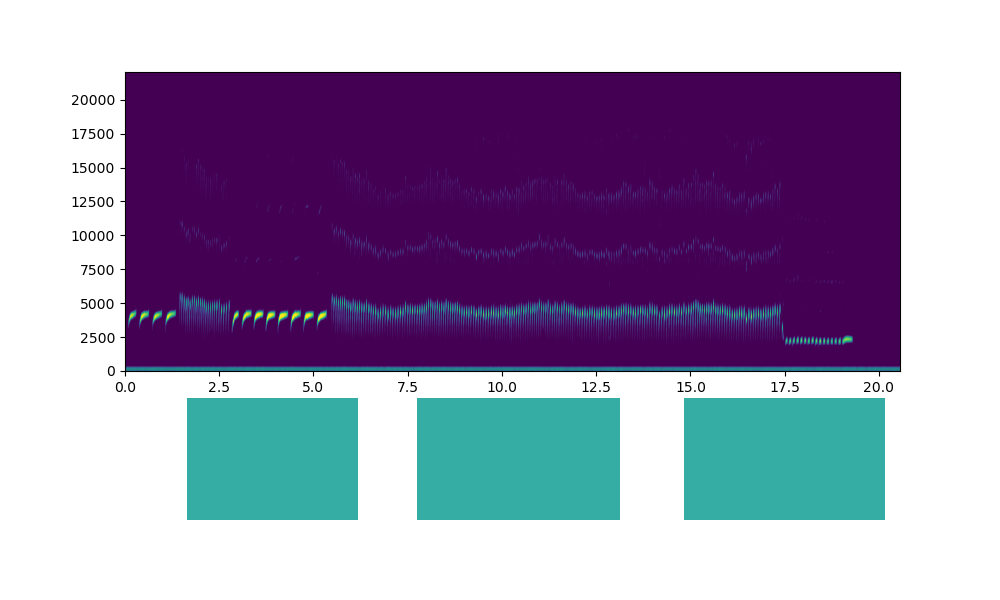

In [12]:
s, t, f, annot = spect_and_annot_from_vocal_num(
    vocal_num=1,
)

figsize = (10, 6)
flim = None

# plt.style.use('seaborn-pastel')

fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(3, 3)
spect_ax = fig.add_subplot(gs[:2, :])
segment_ax = fig.add_subplot(gs[2, :])


img = plot_spect(s, t, f, flim=flim, ax=spect_ax)

rectangles = plot_segments(
        annot, label_color_map, t, ax=segment_ax
    )
segment_ax.set_axis_off()

def init():
    return img, rectangles

N_FRAMES = 600
T_ON = 1.5
T_OFF = 3
DUR = 4
t_ons = np.linspace(T_ON, T_ON + DUR, N_FRAMES)
t_offs = np.linspace(T_OFF, T_OFF + DUR, N_FRAMES)


def update(frame):
    tlim = [t_ons[frame], t_offs[frame]]
    spect_ax.set_xlim(tlim)
    segment_ax.set_xlim(tlim)
    return img, rectangles


anim = FuncAnimation(fig, 
                     update,
                     init_func=init,
                     frames=range(N_FRAMES),
                     interval=100,
                    )

plt.show()

In [ ]:
ani.save("movie.mp4")